#### Import

In [1]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
import datetime as dt 
from netCDF4 import *

#### Exercise 1


In [2]:
sst_file = r"sst.nc"
sst_data = xr.open_dataset(sst_file)
sst_data

<xarray.Dataset> Size: 21MB
Dimensions:  (time: 504, lon: 144, lat: 72)
Coordinates:
  * time     (time) datetime64[ns] 4kB 1981-09-01 1981-10-01 ... 2023-08-01
  * lon      (lon) float32 576B 0.0 2.5 5.0 7.5 10.0 ... 350.0 352.5 355.0 357.5
  * lat      (lat) float32 288B -88.75 -86.25 -83.75 ... 83.75 86.25 88.75
Data variables:
    sst      (time, lat, lon) float32 21MB ...
Attributes:
    CDI:            Climate Data Interface version 1.9.3 (http://mpimet.mpg.d...
    history:        Tue Sep 12 07:33:39 2023: cdo remapbil,r144x72 sst.mon.me...
    source:         NOAA/NCEI https://www.ncei.noaa.gov/data/sea-surface-temp...
    institution:    NOAA/National Centers for Environmental Information
    Conventions:    CF-1.5
    title:          NOAA/NCEI 1/4 Degree Daily Optimum Interpolation Sea Surf...
    References:     https://www.psl.noaa.gov/data/gridded/data.noaa.oisst.v2....
    dataset_title:  NOAA Daily Optimum Interpolation Sea Surface Temperature
    version:        Version 2.1
    comment:        Reynolds, et al.(2007) Daily High-Resolution-Blended Anal...
    CDO:            Climate Data Operators version 1.9.3 (http://mpimet.mpg.d...

In [3]:
# time start at 1 thang 9 nam 1981 and end at 31 thang 8 nam 2023 (504 months)
sst = sst_data.data_vars['sst'].values

In [ ]:
ts, las, los = sst.shape
months = 12
years = ts // months

climatologies = np.zeros((12,las,los))

for month in range(months):
    for la in range(las):
        for lo in range(los):
            climatologies[month, la, lo] = np.nanmean([sst[year*12 + month,la,lo] for year in range(years)])

In [24]:
sst_ym = sst.reshape(years,months,las,los)

(42, 12, 72, 144)

In [47]:
data=xr.open_dataset("sst.nc")
sst_nino34=data.sst.sel(lat=slice(-5,5),lon=slice(190,240))
tmp=sst_nino34.groupby('time.month')
tmp1=tmp-tmp.mean(dim="time")
index_nino34=tmp1.mean(dim=["lat","lon"])

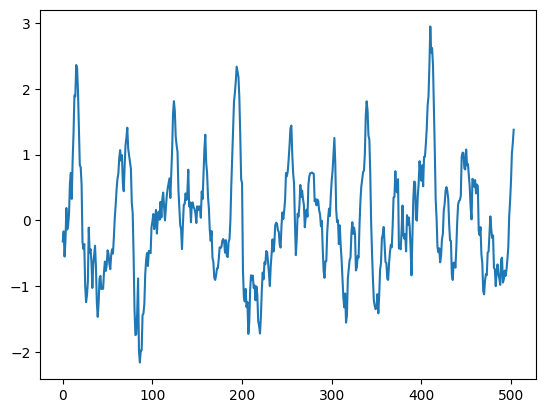

In [48]:
plt.plot(index_nino34)

#### Exercise 2

In [60]:
precipe_file = r"precipe.nc"
precipe_data = xr.open_dataset(precipe_file)
precipe_data

<xarray.Dataset> Size: 22MB
Dimensions:    (lat: 72, lon: 144, time: 536, nv: 2)
Coordinates:
  * lat        (lat) float32 288B -88.75 -86.25 -83.75 ... 83.75 86.25 88.75
  * lon        (lon) float32 576B 1.25 3.75 6.25 8.75 ... 353.8 356.2 358.8
  * time       (time) datetime64[ns] 4kB 1979-01-01 1979-02-01 ... 2023-08-01
Dimensions without coordinates: nv
Data variables:
    time_bnds  (time, nv) datetime64[ns] 9kB ...
    lat_bnds   (lat, nv) float32 576B ...
    lon_bnds   (lon, nv) float32 1kB ...
    precip     (time, lat, lon) float32 22MB ...
Attributes: (12/18)
    Conventions:           CF-1.0
    curator:               Dr. Jian-Jian Wang\nESSIC, University of Maryland ...
    citation:              Adler, R.F., G.J. Huffman, A. Chang, R. Ferraro, P...
    title:                 GPCP Version 2.3 Combined Precipitation Dataset (F...
    platform:              NOAA POES (Polar Orbiting Environmental Satellites)
    source_obs:            CDR RSS SSMI/SSMIS Tbs over ocean \nCDR SSMI/SSMIS...
    ...                    ...
    source:                https://www.ncei.noaa.gov/data/global-precipitatio...
    source_documentation:  https://www.ncdc.noaa.gov/cdr/atmospheric/precipit...
    NCO:                   4.6.9
    history:               Generated at NOAA/ESRL PSD Sep 9 2016 based on dat...
    References:            http://www.psl.noaa.gov/data/gridded/data.gpcp.html
    data_comment:          Interim data covers 2023/07 through latest.